# Kolmogorov-Smirnov data drift detector on CIFAR-10

### Method

The drift detector applies feature-wise two-sample [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) (K-S) tests. For multivariate data, the obtained p-values for each feature are aggregated either via the [Bonferroni](https://mathworld.wolfram.com/BonferroniCorrection.html) or the [False Discovery Rate](http://www.math.tau.ac.il/~ybenja/MyPapers/benjamini_hochberg1995.pdf) (FDR) correction. The Bonferroni correction is more conservative and controls for the probability of at least one false positive. The FDR correction on the other hand allows for an expected fraction of false positives to occur.

For high-dimensional data, we typically want to reduce the dimensionality before computing the feature-wise univariate K-S tests and aggregating those via the chosen correction method. Following suggestions in [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/abs/1810.11953), we incorporate Untrained AutoEncoders (UAE) and black-box shift detection using the classifier's softmax outputs ([BBSDs](https://arxiv.org/abs/1802.03916)) as out-of-the box preprocessing methods and note that [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) can also be easily implemented using `scikit-learn`. Preprocessing methods which do not rely on the classifier will usually pick up drift in the input data, while BBSDs focuses on label shift. The [adversarial detector](https://arxiv.org/abs/2002.09364) which is part of the library can also be transformed into a drift detector picking up drift that reduces the performance of the classification model. We can therefore combine different preprocessing techniques to figure out if there is drift which hurts the model performance, and whether this drift can be classified as input drift or label shift.

### Backend

The method works with both the **PyTorch** and **TensorFlow** frameworks for the optional preprocessing step. Alibi Detect does however not install PyTorch for you. 
Check the [PyTorch docs](https://pytorch.org/) how to do this.


### Dataset

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60,000 32 by 32 RGB images equally distributed over 10 classes. We evaluate the drift detector on the CIFAR-10-C dataset ([Hendrycks & Dietterich, 2019](https://arxiv.org/abs/1903.12261)). The instances in
CIFAR-10-C have been corrupted and perturbed by various types of noise, blur, brightness etc. at different levels of severity, leading to a gradual decline in the classification model performance. We also check for drift against the original test set with class imbalances. 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from alibi_detect.cd import KSDrift
from alibi_detect.models.tensorflow.resnet import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

### Load data

Original CIFAR-10 data:

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

For CIFAR-10-C, we can select from the following corruption types at 5 severity levels:

In [5]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


Let's pick a subset of the corruptions at corruption level 5. Each corruption type consists of perturbations on all of the original test set images.

In [6]:
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

We split the original test set in a reference dataset and a dataset which should not be rejected under the *H<sub>0</sub>* of the K-S test. We also split the corrupted data by corruption type:

In [7]:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref,y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
print(X_ref.shape, X_h0.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3)


In [8]:
# check that the classes are more or less balanced
classes, counts_ref = np.unique(y_ref, return_counts=True)
counts_h0 = np.unique(y_h0, return_counts=True)[1]
print('Class Ref H0')
for cl, cref, ch0 in zip(classes, counts_ref, counts_h0):
    assert cref + ch0 == n_test // 10
    print('{}     {} {}'.format(cl, cref, ch0))

Class Ref H0
0     472 528
1     510 490
2     498 502
3     492 508
4     501 499
5     495 505
6     493 507
7     501 499
8     516 484
9     522 478


In [9]:
n_corr = len(corruption)
X_c = [X_corr[i * n_test:(i + 1) * n_test] for i in range(n_corr)]

We can visualise the same instance for each corruption type:

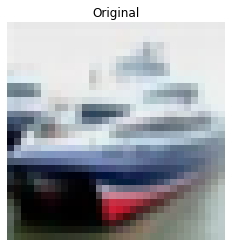

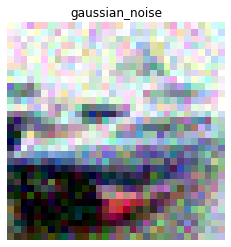

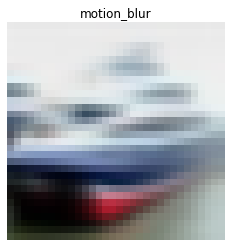

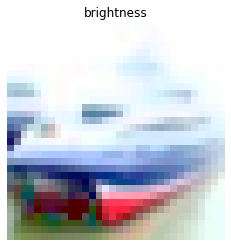

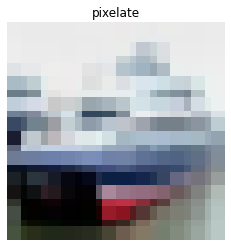

In [10]:
i = 1

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

We can also verify that the performance of a classification model on CIFAR-10 drops significantly on this perturbed dataset:

In [11]:
dataset = 'cifar10'
model = 'resnet32'
clf = fetch_tf_model(dataset, model)
acc = clf.evaluate(scale_by_instance(X_test), y_test, batch_size=128, verbose=0)[1]
print('Test set accuracy:')
print('Original {:.4f}'.format(acc))
clf_accuracy = {'original': acc}
for _ in range(len(corruption)):
    acc = clf.evaluate(scale_by_instance(X_c[_]), y_test, batch_size=128, verbose=0)[1]
    clf_accuracy[corruption[_]] = acc
    print('{} {:.4f}'.format(corruption[_], acc))

Test set accuracy:
Original 0.9278
gaussian_noise 0.2208
motion_blur 0.6339
brightness 0.8913
pixelate 0.3666


Given the drop in performance, it is important that we detect the harmful data drift!

### Detect drift

First we try a drift detector using the **TensorFlow** framework for the preprocessing step. We are trying to detect data drift on high-dimensional (*32x32x3*) data using feature-wise univariate tests. It therefore makes sense to apply dimensionality reduction first. Some dimensionality reduction methods also used in [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/pdf/1810.11953.pdf) are readily available: a randomly initialized encoder (**UAE** or Untrained AutoEncoder in the paper), **BBSDs** (black-box shift detection using the classifier's softmax outputs) and **PCA**.

#### Random encoder

First we try the randomly initialized encoder:

In [10]:
from functools import partial
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift

tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

# define preprocessing function
preprocess_fn = partial(preprocess_drift, model=encoder_net, batch_size=512)

# initialise drift detector
p_val = .05
cd = KSDrift(X_ref, p_val=p_val, preprocess_fn=preprocess_fn)

# we can also save/load an initialised detector
filepath = 'my_path'  # change to directory where detector is saved
save_detector(cd, filepath)
cd = load_detector(filepath)

The p-value used by the detector for the multivariate data with *encoding_dim* features is equal to *p_val / encoding_dim* because of the [Bonferroni correction](https://mathworld.wolfram.com/BonferroniCorrection.html).

In [11]:
assert cd.p_val / cd.n_features == p_val / encoding_dim

Let's check whether the detector thinks drift occurred on the different test sets and time the prediction calls:

In [12]:
from timeit import default_timer as timer

labels = ['No!', 'Yes!']

def make_predictions(cd, x_h0, x_corr, corruption):
    t = timer()
    preds = cd.predict(x_h0)
    dt = timer() - t
    print('No corruption')
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print('Feature-wise p-values:')
    print(preds['data']['p_val'])
    print(f'Time (s) {dt:.3f}')
    
    if isinstance(x_corr, list):
        for x, c in zip(x_corr, corruption):
            t = timer()
            preds = cd.predict(x)
            dt = timer() - t
            print('')
            print(f'Corruption type: {c}')
            print('Drift? {}'.format(labels[preds['data']['is_drift']]))
            print('Feature-wise p-values:')
            print(preds['data']['p_val'])
            print(f'Time (s) {dt:.3f}')

In [13]:
make_predictions(cd, X_h0, X_c, corruption)

No corruption
Drift? No!
Feature-wise p-values:
[0.94146556 0.14195988 0.6440195  0.05512931 0.37907234 0.25943416
 0.87724036 0.48063537 0.11774229 0.677735   0.48063537 0.7442197
 0.08356539 0.14860499 0.31536394 0.31536394 0.61036026 0.36571503
 0.80732274 0.22020556 0.249175   0.46531922 0.11774229 0.45025542
 0.25943416 0.5936282  0.5604951  0.9571862  0.8642828  0.23921937
 0.90134364 0.6945301 ]
Time (s) 0.098

Corruption type: gaussian_noise
Drift? Yes!
Feature-wise p-values:
[4.95750410e-03 7.34658632e-03 5.52912503e-02 1.03268398e-08
 3.38559955e-01 8.17310661e-02 6.79804944e-03 2.71271050e-01
 1.55009609e-02 1.03484383e-02 1.82668434e-03 1.05715834e-01
 5.14261274e-08 1.42579767e-10 1.07582469e-04 1.49479797e-06
 2.90366083e-01 3.92065112e-06 3.53773794e-04 1.99041501e-01
 1.90719927e-03 6.04502577e-03 4.95599561e-10 6.04502577e-03
 5.12230098e-01 5.46741539e-05 3.83900553e-01 1.14905804e-01
 2.80400272e-02 8.04118258e-07 3.30103422e-03 2.05864832e-02]
Time (s) 0.181

Corrup

As expected, drift was only detected on the corrupted datasets. The feature-wise p-values for each univariate K-S test per (encoded) feature before multivariate correction show that most of them are well above the $0.05$ threshold for *H0* and below for the corrupted datasets.

#### BBSDs

For **BBSDs**, we use the classifier's softmax outputs for black-box shift detection. This method is based on [Detecting and Correcting for Label Shift with Black Box Predictors](https://arxiv.org/abs/1802.03916). The ResNet classifier is trained on data standardised by instance so we need to rescale the data.

In [14]:
X_train = scale_by_instance(X_train)
X_test = scale_by_instance(X_test)
X_ref = scale_by_instance(X_ref)
X_h0 = scale_by_instance(X_h0)
X_c = [scale_by_instance(X_c[i]) for i in range(n_corr)]

Now we initialize the detector. Here we use the output of the softmax layer to detect the drift, but other hidden layers can be extracted as well by setting *'layer'* to the index of the desired hidden layer in the model:

In [15]:
from alibi_detect.cd.tensorflow import HiddenOutput

# define preprocessing function, we use the
preprocess_fn = partial(preprocess_drift, model=HiddenOutput(clf, layer=-1), batch_size=128)

cd = KSDrift(X_ref, p_val=p_val, preprocess_fn=preprocess_fn)

Again we can see that the p-value used by the detector for the multivariate data with 10 features (number of CIFAR-10 classes) is equal to *p_val / 10* because of the [Bonferroni correction](https://mathworld.wolfram.com/BonferroniCorrection.html).

In [16]:
assert cd.p_val / cd.n_features == p_val / 10

There is no drift on the original held out test set:

In [17]:
make_predictions(cd, X_h0, X_c, corruption)

No corruption
Drift? No!
Feature-wise p-values:
[0.11774229 0.52796143 0.19387017 0.20236294 0.496191   0.72781175
 0.12345381 0.420929   0.8367454  0.7604178 ]
Time (s) 1.003

Corruption type: gaussian_noise
Drift? Yes!
Feature-wise p-values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Time (s) 1.970

Corruption type: motion_blur
Drift? Yes!
Feature-wise p-values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Time (s) 1.798

Corruption type: brightness
Drift? Yes!
Feature-wise p-values:
[0.0000000e+00 4.2024049e-15 2.8963613e-33 4.8499879e-07 2.3718185e-15
 1.2473309e-05 2.9714003e-30 1.0611427e-09 4.6048109e-12 4.1857830e-17]
Time (s) 1.975

Corruption type: pixelate
Drift? Yes!
Feature-wise p-values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Time (s) 1.894


### Label drift

We can also check what happens when we introduce class imbalances between the reference data *X_ref* and the tested data *X_imb*. The reference data will use $75$% of the instances of the first 5 classes and only $25$% of the last 5. The data used for drift testing then uses respectively $25$% and $75$% of the test instances for the first and last 5 classes.

In [19]:
np.random.seed(0)
# get index for each class in the test set
num_classes = len(np.unique(y_test))
idx_by_class = [np.where(y_test == c)[0] for c in range(num_classes)]
# sample imbalanced data for different classes for X_ref and X_imb
perc_ref = .75
perc_ref_by_class = [perc_ref if c < 5 else 1 - perc_ref for c in range(num_classes)]
n_by_class = n_test // num_classes
X_ref = []
X_imb, y_imb = [], []
for _ in range(num_classes):
    idx_class_ref = np.random.choice(n_by_class, size=int(perc_ref_by_class[_] * n_by_class), replace=False)
    idx_ref = idx_by_class[_][idx_class_ref]
    idx_class_imb = np.delete(np.arange(n_by_class), idx_class_ref, axis=0)
    idx_imb = idx_by_class[_][idx_class_imb]
    assert idx_ref != idx_imb
    X_ref.append(X_test[idx_ref])
    X_imb.append(X_test[idx_imb])
    y_imb.append(y_test[idx_imb])
X_ref = np.concatenate(X_ref)
X_imb = np.concatenate(X_imb)
y_imb = np.concatenate(y_imb)
print(X_ref.shape, X_imb.shape, y_imb.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3) (5000,)


Update reference dataset for the detector and make predictions. Note that we store the preprocessed reference data since the `preprocess_x_ref` kwarg is by default True:

In [20]:
cd.x_ref = cd.preprocess_fn(X_ref)

In [21]:
preds_imb = cd.predict(X_imb)
print('Drift? {}'.format(labels[preds_imb['data']['is_drift']]))
print(preds_imb['data']['p_val'])

Drift? Yes!
[6.10830360e-20 1.32319470e-20 7.62410424e-29 1.05537245e-17
 7.68910424e-23 1.57479264e-15 5.77457112e-19 1.94419707e-20
 5.02102509e-21 4.13147353e-21]


### Update reference data

So far we have kept the reference data the same throughout the experiments. It is possible however that we want to test a new batch against the last *N* instances or against a batch of instances of fixed size where we give each instance we have seen up until now the same chance of being in the reference batch ([reservoir sampling](https://en.wikipedia.org/wiki/Reservoir_sampling)). The `update_x_ref` argument allows you to change the reference data update rule. It is a Dict which takes as key the update rule (*'last'* for last *N* instances or *'reservoir_sampling'*) and as value the batch size *N* of the reference data. You can also save the detector after the prediction calls to save the updated reference data.

In [22]:
N = 7500
cd = KSDrift(X_ref, p_val=.05, preprocess_fn=preprocess_fn, update_x_ref={'reservoir_sampling': N})

The reference data is now updated with each `predict` call. Say we start with our imbalanced reference set and make a prediction on the remaining test set data *X_imb*, then the drift detector will figure out data drift has occurred.

In [23]:
preds_imb = cd.predict(X_imb)
print('Drift? {}'.format(labels[preds_imb['data']['is_drift']]))

Drift? Yes!


We can now see that the reference data consists of *N* instances, obtained through reservoir sampling.

In [24]:
assert cd.x_ref.shape[0] == N

We then draw a random sample from the training set and compare it with the updated reference data. This still highlights that there is data drift but will update the reference data again:

In [25]:
np.random.seed(0)
perc_train = .5
n_train = X_train.shape[0]
idx_train = np.random.choice(n_train, size=int(perc_train * n_train), replace=False)

In [26]:
preds_train = cd.predict(X_train[idx_train])
print('Drift? {}'.format(labels[preds_train['data']['is_drift']]))

Drift? Yes!


When we draw a new sample from the training set, it highlights that it is not drifting anymore against the reservoir in *X_ref*.

In [27]:
np.random.seed(1)
perc_train = .1
idx_train = np.random.choice(n_train, size=int(perc_train * n_train), replace=False)
preds_train = cd.predict(X_train[idx_train])
print('Drift? {}'.format(labels[preds_train['data']['is_drift']]))

Drift? No!


### Multivariate correction mechanism

Instead of the Bonferroni correction for multivariate data, we can also use the less conservative [False Discovery Rate](http://www.math.tau.ac.il/~ybenja/MyPapers/benjamini_hochberg1995.pdf) (FDR) correction. See [here](https://riffyn.com/riffyn-blog/2017/10/29/false-discovery-rate) or [here](https://matthew-brett.github.io/teaching/fdr.html) for nice explanations. While the Bonferroni correction controls the probability of at least one false positive, the FDR correction controls for an expected amount of false positives. The `p_val` argument at initialisation time can be interpreted as the acceptable q-value when the FDR correction is applied.

In [28]:
cd = KSDrift(X_ref, p_val=.05, preprocess_fn=preprocess_fn, correction='fdr')

preds_imb = cd.predict(X_imb)
print('Drift? {}'.format(labels[preds_imb['data']['is_drift']]))

Drift? Yes!


### Adversarial autoencoder as a malicious drift detector

We can leverage the adversarial scores obtained from an [adversarial autoencoder](https://arxiv.org/abs/2002.09364)  trained on normal data and transform it into a data drift detector. The score function of the adversarial autoencoder becomes the preprocessing function for the drift detector. The K-S test is then a simple univariate test on the adversarial scores. Importantly, an adversarial drift detector flags **malicious data drift**. We can fetch the pretrained adversarial detector from a [Google Cloud Bucket](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/ad/cifar10/resnet32) or train one from scratch:

In [29]:
load_pretrained = True

In [30]:
# change filepath to (absolute) directory where model is downloaded
filepath = os.path.join(os.getcwd(), 'my_path')
if load_pretrained:
    detector_type = 'adversarial'
    detector_name = 'base'
    ad = fetch_detector(filepath, detector_type, dataset, detector_name, model=model)
    filepath = os.path.join(filepath, detector_name)
else:  # train detector from scratch
    # define encoder and decoder networks
    encoder_net = tf.keras.Sequential(
            [
                InputLayer(input_shape=(32, 32, 3)),
                Conv2D(32, 4, strides=2, padding='same', 
                       activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2D(64, 4, strides=2, padding='same', 
                       activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2D(256, 4, strides=2, padding='same', 
                       activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Flatten(),
                Dense(40)
            ]
        )
    
    decoder_net = tf.keras.Sequential(
        [
                InputLayer(input_shape=(40,)),
                Dense(4 * 4 * 128, activation=tf.nn.relu),
                Reshape(target_shape=(4, 4, 128)),
                Conv2DTranspose(256, 4, strides=2, padding='same', 
                                activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2DTranspose(64, 4, strides=2, padding='same', 
                                activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2DTranspose(3, 4, strides=2, padding='same', 
                                activation=None, kernel_regularizer=l1(1e-5))
            ]
        )
    
    # initialise and train detector
    ad = AdversarialAE(encoder_net=encoder_net, decoder_net=decoder_net, model=clf)
    ad.fit(X_train, epochs=50, batch_size=128, verbose=True)
    
    # save the trained adversarial detector
    save_detector(ad, filepath)

4300800/4295560 [==============================] - 0s 0us/step
8192/71 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Initialise the drift detector:

In [34]:
np.random.seed(0)
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
X_ref = scale_by_instance(X_test[idx])

# adversarial score fn = preprocess step
preprocess_fn = partial(ad.score, batch_size=128)

cd = KSDrift(X_ref, p_val=.05, preprocess_fn=preprocess_fn)

Make drift predictions on the original test set and corrupted data:

In [35]:
clf_accuracy['h0'] = clf.evaluate(X_h0, y_h0, batch_size=128, verbose=0)[1]
preds_h0 = cd.predict(X_h0)
print('H0: Accuracy {:.4f} -- Drift? {}'.format(
    clf_accuracy['h0'], labels[preds_h0['data']['is_drift']]))
clf_accuracy['imb'] = clf.evaluate(X_imb, y_imb, batch_size=128, verbose=0)[1]
preds_imb = cd.predict(X_imb)
print('imbalance: Accuracy {:.4f} -- Drift? {}'.format(
    clf_accuracy['imb'], labels[preds_imb['data']['is_drift']]))
for x, c in zip(X_c, corruption):
    preds = cd.predict(x)
    print('{}: Accuracy {:.4f} -- Drift? {}'.format(
        c, clf_accuracy[c],labels[preds['data']['is_drift']]))

H0: Accuracy 0.9286 -- Drift? No!
imbalance: Accuracy 0.9282 -- Drift? No!
gaussian_noise: Accuracy 0.2208 -- Drift? Yes!
motion_blur: Accuracy 0.6339 -- Drift? Yes!
brightness: Accuracy 0.8913 -- Drift? Yes!
pixelate: Accuracy 0.3666 -- Drift? Yes!


While *X_imb* clearly exhibits input data drift due to the introduced class imbalances, it is not flagged by the adversarial drift detector since the performance of the classifier is not affected and the drift is not malicious. We can visualise this by plotting the adversarial scores together with the harmfulness of the data corruption as reflected by the drop in classifier accuracy:

In [36]:
adv_scores = {}
score = ad.score(X_ref, batch_size=128)
adv_scores['original'] = {'mean': score.mean(), 'std': score.std()}
score = ad.score(X_h0, batch_size=128)
adv_scores['h0'] = {'mean': score.mean(), 'std': score.std()}
score = ad.score(X_imb, batch_size=128)
adv_scores['imb'] = {'mean': score.mean(), 'std': score.std()}

for x, c in zip(X_c, corruption):
    score_x = ad.score(x, batch_size=128)
    adv_scores[c] = {'mean': score_x.mean(), 'std': score_x.std()}

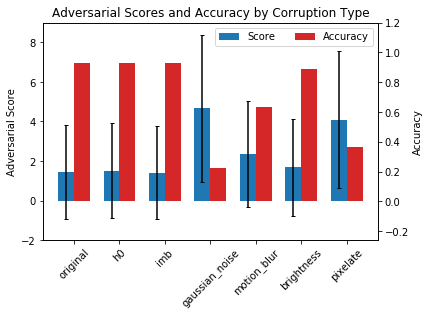

In [37]:
mu = [v['mean'] for _, v in adv_scores.items()]
stdev = [v['std'] for _, v in adv_scores.items()]
xlabels = list(adv_scores.keys())
acc = [clf_accuracy[label] for label in xlabels]
xticks = np.arange(len(mu))

width = .35

fig, ax = plt.subplots()
ax2 = ax.twinx()

p1 = ax.bar(xticks, mu, width, yerr=stdev, capsize=2)
color = 'tab:red'
p2 = ax2.bar(xticks + width, acc, width, color=color)

ax.set_title('Adversarial Scores and Accuracy by Corruption Type')
ax.set_xticks(xticks + width / 2)
ax.set_xticklabels(xlabels, rotation=45)
ax.legend((p1[0], p2[0]), ('Score', 'Accuracy'), loc='upper right', ncol=2)
ax.set_ylabel('Adversarial Score')

color = 'tab:red'
ax2.set_ylabel('Accuracy')
ax2.set_ylim((-.26,1.2))
ax.set_ylim((-2,9))

plt.show()

We can therefore **use the scores of the detector itself to quantify the harmfulness of the drift**! We can generalise this to all the corruptions at each severity level in CIFAR-10-C:

In [38]:
def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return (y_true == y_pred).astype(int).sum() / y_true.shape[0]

In [40]:
from alibi_detect.utils.prediction import predict_batch

severities = [1, 2, 3, 4, 5]

score_drift = {
    1: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    2: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    3: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    4: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    5: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
}

y_pred = predict_batch(clf, X_test, batch_size=256, return_class=True)
score_x = ad.score(X_test, batch_size=256)

for s in severities:
    print('\nSeverity: {} of {}'.format(s, len(severities)))
    
    print('Loading corrupted dataset...')
    X_corr, y_corr = fetch_cifar10c(corruption=corruptions, severity=s, return_X_y=True)
    X_corr = X_corr.astype('float32')
    
    print('Preprocess data...')
    X_corr = scale_by_instance(X_corr)
    
    print('Make predictions on corrupted dataset...')
    y_pred_corr = predict_batch(clf, X_corr, batch_size=256, return_class=True)
    
    print('Compute adversarial scores on corrupted dataset...')
    score_corr = ad.score(X_corr, batch_size=256)
    
    print('Get labels for malicious corruptions...')
    labels_corr = np.zeros(score_corr.shape[0])
    repeat = y_corr.shape[0] // y_test.shape[0]
    y_pred_repeat = np.tile(y_pred, (repeat,))
    # malicious/harmful corruption: original prediction correct but 
    # prediction on corrupted data incorrect
    idx_orig_right = np.where(y_pred_repeat == y_corr)[0]
    idx_corr_wrong = np.where(y_pred_corr != y_corr)[0]
    idx_harmful = np.intersect1d(idx_orig_right, idx_corr_wrong)
    labels_corr[idx_harmful] = 1
    labels = np.concatenate([np.zeros(X_test.shape[0]), labels_corr]).astype(int)
    # harmless corruption: original prediction correct and prediction
    # on corrupted data correct
    idx_corr_right = np.where(y_pred_corr == y_corr)[0]
    idx_harmless = np.intersect1d(idx_orig_right, idx_corr_right)
    
    score_drift[s]['all'] = score_corr
    score_drift[s]['harm'] = score_corr[idx_harmful]
    score_drift[s]['noharm'] = score_corr[idx_harmless]
    score_drift[s]['acc'] = accuracy(y_corr, y_pred_corr)


Severity: 1 of 5
Loading corrupted dataset...
Preprocess data...
Make predictions on corrupted dataset...
Compute adversarial scores on corrupted dataset...
Get labels for malicious corruptions...

Severity: 2 of 5
Loading corrupted dataset...
Preprocess data...
Make predictions on corrupted dataset...
Compute adversarial scores on corrupted dataset...
Get labels for malicious corruptions...

Severity: 3 of 5
Loading corrupted dataset...
Preprocess data...
Make predictions on corrupted dataset...
Compute adversarial scores on corrupted dataset...
Get labels for malicious corruptions...

Severity: 4 of 5
Loading corrupted dataset...
Preprocess data...
Make predictions on corrupted dataset...
Compute adversarial scores on corrupted dataset...
Get labels for malicious corruptions...

Severity: 5 of 5
Loading corrupted dataset...
Preprocess data...
Make predictions on corrupted dataset...
Compute adversarial scores on corrupted dataset...
Get labels for malicious corruptions...


We now compute mean scores and standard deviations per severity level and plot the results. The plot shows the mean adversarial scores (lhs) and ResNet-32 accuracies (rhs) for increasing data corruption severity levels. Level 0 corresponds to the original test set. Harmful scores  are scores from instances which have been flipped from the correct to an incorrect prediction because of the corruption. Not harmful means that the prediction was unchanged after the corruption.

In [41]:
mu_noharm, std_noharm = [], []
mu_harm, std_harm = [], []
acc = [clf_accuracy['original']]
for k, v in score_drift.items():
    mu_noharm.append(v['noharm'].mean())
    std_noharm.append(v['noharm'].std())
    mu_harm.append(v['harm'].mean())
    std_harm.append(v['harm'].std())
    acc.append(v['acc'])

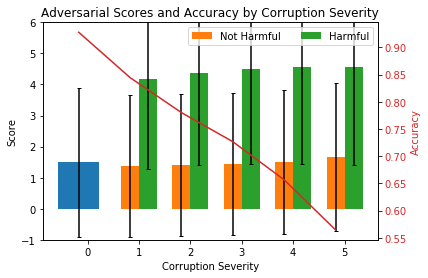

In [42]:
plot_labels = ['0', '1', '2', '3', '4', '5']

N = 6
ind = np.arange(N)
width = .35

fig_bar_cd, ax = plt.subplots()
ax2 = ax.twinx()

p0 = ax.bar(ind[0], score_x.mean(), yerr=score_x.std(), capsize=2)
p1 = ax.bar(ind[1:], mu_noharm, width, yerr=std_noharm, capsize=2)
p2 = ax.bar(ind[1:] + width, mu_harm, width, yerr=std_harm, capsize=2)

ax.set_title('Adversarial Scores and Accuracy by Corruption Severity')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(plot_labels)
ax.set_ylim((-1,6))
ax.legend((p1[0], p2[0]), ('Not Harmful', 'Harmful'), loc='upper right', ncol=2)
ax.set_ylabel('Score')
ax.set_xlabel('Corruption Severity')

color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()